# 
<center><h1> Homework 3: ConvNet
<center> Apoorv Sharma </center>
    <center> DATA 598 (Winter 2022), University of Washington </center>

# 1. The Effect of BatchNorm on a ConvNet

In this exercise, we will combine both the topics we covered in class this week. The goal of this exercise is to
visualize the effective smoothness of a covolutional neural network with and without batch normalization.

Let $\phi(.; \omega) : \mathbb{R}^{28x28} \rightarrow \mathbb{R}^{10}$ denote a convolution neural network with parameters $\omega$ which takes in an image of size $28 × 28$ and returns a score for 10 output classes (All the MLPs and ConvNets we have considered so far fit this input-output description of $\phi$, upto a reshaping of the images). Consider the
objective function:

$$
f(\omega) = \frac{1}{n} \sum_{i=1}^{n} l(y_i, \phi(x_i,\omega))
$$

Concretely, your task is as follows:
* Use the FashionMNIST dataset. Perform the same preprocessing as in previous homeworks.
* Code up a ConvNet module with two convolutional layers with the following structure (the input has 1 channel, so we write the image as 1 × 28 × 28):

In [1]:
import torch
import numpy as np

from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy, relu

import pickle
import os
import copy
import math

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
path = './models'
if not os.path.exists(path):
  os.makedirs(path)

#### CovNet1 Specification

* k denotes the kernel/filter size and “#filters” denotes the number of filters
* In PyTorch, the convolutions and pooling operations on images are called “Conv2d” and “Max-Pool2d” respectively.
* For the first conv layer, the specification asks you to use a kernel size of 5, and a padding of 2. The number of input channels is the same as the number of channels from the preceding layer (here, it is 1 since the preceding layer is just the image with 1 channel). Finally, the number of output channels is the same as the number of filters (here, 16). The second conv layer is constructed in a similarly; the number of input channels is the same as the number of outputs channels of the first conv layer (since ReLU and MaxPool do not change the number of channels). When not specified, we take the stride to be 1.
* The last “Linear” layer takes in the output of the second MaxPool and flattens it down to a vector of a certain size S. You are to figure out this size by running a dummy input through these layers and analyzing the output size, as we have done in the lab. The linear layer then maps this S-dimensional input to a 10-dimensional output, one for each class.

In [3]:
class CovNetNoBatchNorm(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        # cov_ensemble_2 has shape: torch.Size([1, 32, 26, 26])
        self.fully_connected_layer = torch.nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # reshape input; convolutions need a channel
        out = self.conv_ensemble_1(x)  # first convolution + relu + pooling
        out = self.conv_ensemble_2(out) # second convolution + relu + pooling
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

In [4]:
image_size = 28
random_image = torch.randn(1, 1, image_size, image_size)

In [5]:
class CovNetBatchNorm(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(16))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(32))
        
        # cov_ensemble_2 has shape: torch.Size([1, 32, 26, 26])
        self.fully_connected_layer = torch.nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # reshape input; convolutions need a channel
        out = self.conv_ensemble_1(x)  # first convolution + relu + pooling
        out = self.conv_ensemble_2(out) # second convolution + relu + pooling
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

Test the models and ensure that they work

In [6]:
m1 = CovNetNoBatchNorm(num_classes=10)

In [7]:
m2 = CovNetBatchNorm(num_classes=10)

In [8]:
output = m1(random_image)
print(output)

tensor([[-8.3779e-02,  1.9382e-04,  6.5174e-02, -4.2130e-01,  7.6804e-02,
          1.0856e-01,  7.5034e-02,  2.3799e-01,  7.1075e-02, -1.8772e-02]],
       grad_fn=<AddmmBackward0>)


In [9]:
output = m2(random_image)
print(output)

tensor([[-1.0892,  0.8060, -0.9953, -0.8221, -0.2303, -0.5744,  0.3975, -0.4681,
         -0.0533, -0.3376]], grad_fn=<AddmmBackward0>)


In [10]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


In [11]:
def compute_objective(model, X, y):
    """ Compute the multinomial logistic loss. 
        model is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = model(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(model, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    is_train = model.training  # if True, model is in training mode
    model.eval()  # use eval mode for accuracy
    score = model(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    if is_train:  # switch back to train mode if appropriate
        model.train()
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(model, verbose=False):
    is_train = model.training  # if True, model is in training mode
    model.eval()  # switch to eval mode
    train_loss = compute_objective(model, X_train, y_train)
    test_loss = compute_objective(model, X_test, y_test)
    train_accuracy = compute_accuracy(model, X_train, y_train)
    test_accuracy = compute_accuracy(model, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    if is_train:  # switch back to train mode if appropriate
        model.train()
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [12]:
def minibatch_sgd_one_pass(model, X, y, learning_rate, batch_size, verbose=False):
    model.train()
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
        model.train()  # make sure we are in train mode
        # compute the objective. 
        objective = compute_objective(model, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
    return model

In [13]:
def compute_effective_local_smoothness(model, X, y, learning_rate, batch_size, verbose=False):
    
    # choose random samples of size batch_size
    idxs = np.random.choice(X.shape[0], size=(batch_size,))
    
    # STEP 1: COMPUTE 'U'
    model.train()
    objective_u = compute_objective(model, X[idxs], y[idxs]) 

    # compute the gradient using automatic differentiation
    gradients_u = torch.autograd.grad(outputs=objective_u, inputs=model.parameters())
    u = [-learning_rate * g for g in gradients_u]
    
    model.eval()
    # STEP 2: COMPUTE F(W)
    objective = compute_objective(model, X, y)
    gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
    
    # STEP 3: COMPUTE F(U + W)
    model_new = copy.deepcopy(model)
    
    # perform SGD update - to get f(u+w)
    with torch.no_grad():
        for (w, g) in zip(model_new.parameters(), gradients_u):
            w -= learning_rate * g

    objective_new = compute_objective(model_new, X, y)
    gradients_new = torch.autograd.grad(outputs=objective_new, inputs=model_new.parameters())
    
    # STEP 4: COMPUTE EFFECTIVE LOCAL SMOOTHNESS
    effective_local_smoothness = 0
    for i, (g_new, g_old) in enumerate(zip(gradients_new, gradients)):
        effective_local_smoothness += torch.norm(g_new - g_old)
        if verbose:
            print(f'\tIteration: {i} has L_hat : {effective_local_smoothness}')
    effective_local_smoothness = math.sqrt(effective_local_smoothness)
    
    u_l2_norm = 0
    for i, u_val in enumerate(u):
        u_l2_norm += torch.norm(u_val)
        if verbose:
            print(f'\tIteration: {i} has u_l2_norm : {u_l2_norm}')
    u_l2_norm = math.sqrt(u_l2_norm)
    
    effective_local_smoothness /= u_l2_norm
    if verbose:
        print(f'Final L_hat : {effective_local_smoothness}')
    
    return effective_local_smoothness


In [14]:
batch_logs = []
learning_rate = 0.04
num_passes = 10
batch_size = 32

m1 = CovNetNoBatchNorm(num_classes=10)
m2 = CovNetBatchNorm(num_classes=10)

for i, model in enumerate([m1, m2]):
    logs = []
    log = list(compute_logs(model, False)) +\
            [torch.tensor(compute_effective_local_smoothness(model, X_train, y_train, learning_rate, 
                                                batch_size=batch_size, verbose=False))]
    logs.append(log)
    print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}, Smoothness = {:.3f}').format(
                logs[-1][0].item(), logs[-1][1].item(), 
                logs[-1][2].item(), logs[-1][3].item(), logs[-1][4].item()))
    
    for _ in range(num_passes):
        model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, 
                                       batch_size=batch_size, verbose=True)
        
        log = list(compute_logs(model, False)) +\
            [torch.tensor(compute_effective_local_smoothness(model, X_train, y_train, learning_rate, 
                                                batch_size=batch_size, verbose=False))]
        logs.append(log)
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}, Smoothness = {:.3f}').format(
                logs[-1][0].item(), logs[-1][1].item(), 
                logs[-1][2].item(), logs[-1][3].item(), logs[-1][4].item()))
    
    # done training this mode - append logs
    batch_logs.append(logs)
    
    # save the model parms
    torch.save(model.state_dict(), f'./models/{type(model).__name__}.pt')
    
    print()

with open('./models/logs.pkl', 'wb') as f:
    pickle.dump(batch_logs, f)

Train Loss = 2.317, Train Accuracy = 0.098, Test Loss = 2.320, Test Accuracy = 0.092, Smoothness = 2.312
0.6077157165691467
Train Loss = 0.538, Train Accuracy = 0.815, Test Loss = 0.598, Test Accuracy = 0.790, Smoothness = 3.288
0.33318486105681944
Train Loss = 0.453, Train Accuracy = 0.832, Test Loss = 0.544, Test Accuracy = 0.809, Smoothness = 3.893
0.2919037683915744
Train Loss = 0.378, Train Accuracy = 0.867, Test Loss = 0.481, Test Accuracy = 0.839, Smoothness = 2.704
0.24160208177000478
Train Loss = 0.341, Train Accuracy = 0.879, Test Loss = 0.486, Test Accuracy = 0.836, Smoothness = 2.668
0.19952211269952672
Train Loss = 0.309, Train Accuracy = 0.889, Test Loss = 0.466, Test Accuracy = 0.851, Smoothness = 2.600
0.2036377096688466
Train Loss = 0.278, Train Accuracy = 0.899, Test Loss = 0.465, Test Accuracy = 0.855, Smoothness = 3.054
0.16755015007042304
Train Loss = 0.251, Train Accuracy = 0.914, Test Loss = 0.449, Test Accuracy = 0.863, Smoothness = 2.428
0.15666239709979773
Tra

In [15]:
without_norm_logs, with_norm_logs = batch_logs

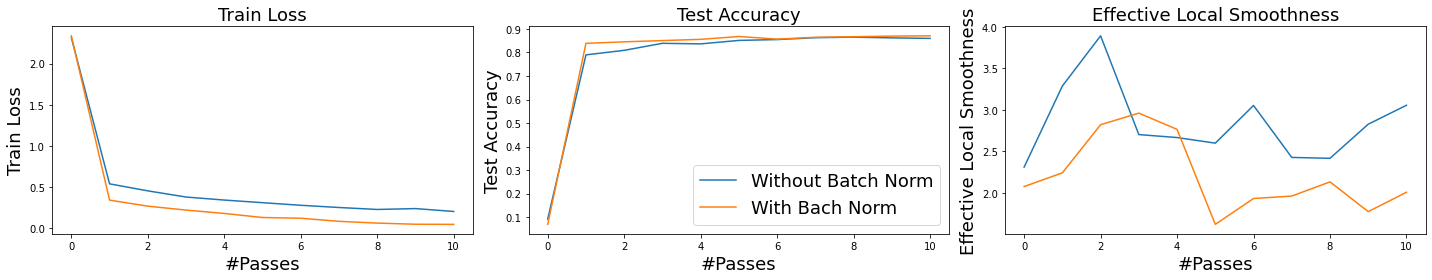

In [16]:
f, ax = plt.subplots(1, 3, figsize=(20, 4))

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Test Accuracy', fontsize=18)
ax[2].set_title('Effective Local Smoothness', fontsize=18)

# Train Loss
ax[0].set_xlabel('#Passes', fontsize=18)
ax[0].set_ylabel('Train Loss', fontsize=18)
ax[0].plot(list(map(lambda x: x[0].item(), without_norm_logs)), label=f'Without Batch Norm')
ax[0].plot(list(map(lambda x: x[0].item(), with_norm_logs)), label='With Bach Norm')

# Test Accuracy
ax[1].set_xlabel('#Passes', fontsize=18)
ax[1].set_ylabel('Test Accuracy', fontsize=18)
ax[1].plot(list(map(lambda x: x[3], without_norm_logs)), label=f'Without Batch Norm')
ax[1].plot(list(map(lambda x: x[3], with_norm_logs)), label='With Bach Norm')

# Effective Local Smoothness
ax[2].set_xlabel('#Passes', fontsize=18)
ax[2].set_ylabel('Effective Local Smoothness', fontsize=18)
ax[2].plot(list(map(lambda x: x[4], without_norm_logs)), label=f'Without Batch Norm')
ax[2].plot(list(map(lambda x: x[4], with_norm_logs)), label='With Bach Norm')
        
ax[1].legend(fontsize=18)
plt.tight_layout()

Using batch norm results improved performance: lower training loss and slightly higher accuracy. Moreover, the smoothness value is also lower. 

We can use a larger learning rate since the smoothness value is lower when using batch norm. This is because:

$\eta = \frac{1}{L}$, where $L$ is the smoothness and $\eta$ is the learning rate. 

Thus a smaller $L$ value results in a larger $\eta$ value.

# 2. Max pooling or convolution with stride

In this exercise, we will compare two alternatives: convolution + max pooling, as considered in Exercise
1, versus a convolution with a stride greater than 1. Throughout this exercise, we do not use batch norm.

In [17]:
class CovNetNoBatchNormSameSize(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2, stride=2),
            torch.nn.ReLU())
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=2),
            torch.nn.ReLU())
        
        # cov_ensemble_2 has shape: torch.Size([1, 32, 26, 26])
        self.fully_connected_layer = torch.nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # reshape input; convolutions need a channel
        out = self.conv_ensemble_1(x)  # first convolution + relu + pooling
        #print(f'Layer 2 Input: {out.shape}')
        out = self.conv_ensemble_2(out) # second convolution + relu + pooling
        #print(f'Final Input: {out.shape}')
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out

Figure out the right stride so that the input to the second conv layer and the final linear layer are
identical in shape to those in the previous exercise.

In [18]:
m3 = CovNetNoBatchNormSameSize(num_classes=10)

In [19]:
m4 = CovNetNoBatchNorm(num_classes=10)

In [20]:
'''
Trying to match the following (Ex 1)

Layer 2 Input: torch.Size([1, 16, 14, 14])
Final Input: torch.Size([1, 32, 7, 7])
'''

m3(random_image)

tensor([[-0.1364,  0.0222,  0.0544, -0.1002, -0.1649, -0.0130,  0.1072, -0.0075,
          0.1371, -0.0609]], grad_fn=<AddmmBackward0>)

Train each ConvNet, with a learning rate of 0.04 and a batch size of 32 for 10 passes through the data. The rest of the setup, including dataset preprocessing, is identical to Exercise 1.

In [21]:
batch_logs_2 = []
learning_rate = 0.04
num_passes = 10
batch_size = 32

m3 = CovNetNoBatchNormSameSize(num_classes=10)
m4 = CovNetNoBatchNorm(num_classes=10)

for i, model in enumerate([m3, m4]):
    logs = []
    logs.append(compute_logs(model, True))
    for _ in range(num_passes):
        model = minibatch_sgd_one_pass(model, X_train, y_train, learning_rate, 
                                       batch_size=batch_size, verbose=True)
        
        logs.append(compute_logs(model, True))
    
    # done training this mode - append logs
    batch_logs_2.append(logs)
    
    # save the model parms
    torch.save(model.state_dict(), f'./models/{type(model).__name__}_ex2.pt')
    
    print()

with open('./models/logs_2.pkl', 'wb') as f:
    pickle.dump(batch_logs_2, f)

Train Loss = 2.311, Train Accuracy = 0.063, Test Loss = 2.311, Test Accuracy = 0.059
0.605155238223401
Train Loss = 0.577, Train Accuracy = 0.785, Test Loss = 0.625, Test Accuracy = 0.767
0.3403315510535405
Train Loss = 0.473, Train Accuracy = 0.837, Test Loss = 0.549, Test Accuracy = 0.810
0.29171773399465933
Train Loss = 0.417, Train Accuracy = 0.844, Test Loss = 0.507, Test Accuracy = 0.816
0.2423640320297841
Train Loss = 0.371, Train Accuracy = 0.868, Test Loss = 0.486, Test Accuracy = 0.826
0.23680898904886663
Train Loss = 0.336, Train Accuracy = 0.874, Test Loss = 0.468, Test Accuracy = 0.834
0.21623955207096252
Train Loss = 0.324, Train Accuracy = 0.885, Test Loss = 0.470, Test Accuracy = 0.836
0.20026351094434205
Train Loss = 0.308, Train Accuracy = 0.889, Test Loss = 0.478, Test Accuracy = 0.845
0.18325313030500676
Train Loss = 0.280, Train Accuracy = 0.900, Test Loss = 0.448, Test Accuracy = 0.848
0.17247257084098197
Train Loss = 0.262, Train Accuracy = 0.908, Test Loss = 0.4

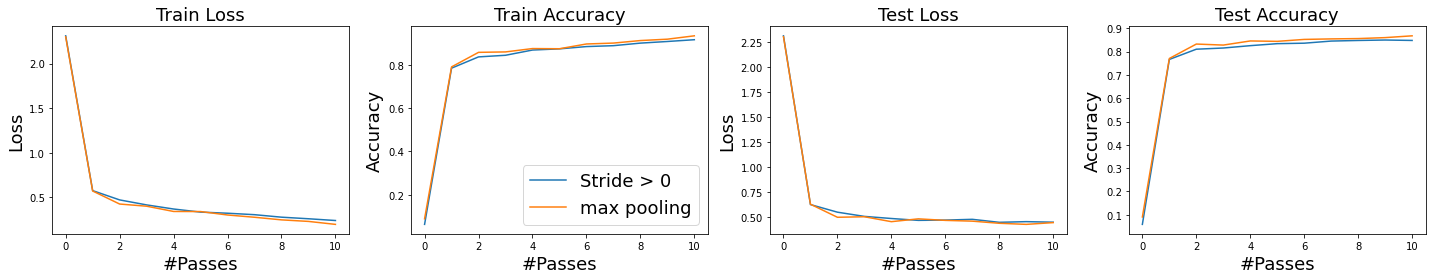

In [26]:
f, ax = plt.subplots(1, 4, figsize=(20, 4))

ax[0].set_title('Train Loss', fontsize=18)
ax[1].set_title('Train Accuracy', fontsize=18)
ax[2].set_title('Test Loss', fontsize=18)
ax[3].set_title('Test Accuracy', fontsize=18)

#TODO: Swap the case for j
for j, case in enumerate(batch_logs_2):
    if j == 0:
        line_label = f'Stride > 0'
    else:
        line_label = f'max pooling'

    for i in range(4):
        ax[i].set_xlabel('#Passes', fontsize=18)
        ax[i].set_ylabel('Loss' if i%2==0 else 'Accuracy', fontsize=18)
        ax[i].plot(list(map(lambda x: x[i], case)), label=line_label)
        
ax[1].legend(fontsize=18)
plt.tight_layout()

There is no observable difference in the performance of the 2 models